In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from matplotlib.animation import FuncAnimation, PillowWriter 
from matplotlib import cm

import pandas as pd
import numpy as np
from tqdm import tqdm
from random import *
import random
import os #os, ramdom의 경우 기본적으로 주어지기 때문에 setup.py에 하지 않는다.
import warnings

from celluloid import Camera
import seaborn as sns

warnings.filterwarnings(action='ignore') 

## data

In [15]:
# change path to relative path - only for publishing

# current_directory = os.path.dirname(os.path.abspath(__file__))
# os.chdir(current_directory)

space_no_ent = pd.read_excel("./Data/simulData/exp_space2.xlsx", header = None)
space_ent = pd.read_excel("./Data/simulData/exp_space3.xlsx", header = None)

## makeSpace

In [16]:
def makeSpace(space_x = 10, space_y = 10, DFMap = [None], obstacles = None, chairs = None, FDD = False, entrance = None): #default: x, y = 20m
    '''
    to make indoor space for simulation
    0: none
    1: obstacle
    2: chair
    3: entrance
    
    Parameters
    ----------
    space_x: indoor x size
    space_y: indoor y size
    DFMap: dataframe displaying map
    obstacles: the number of obstacles
    chairs: the number of chairs
    FDD: print FDD (Flow Disturbance Degree) or not
    entrance: location and size of entrance e.g., {'x': [15,15], 'y': [0,3]} -> x: 15 to 15, y: 0 to 3

    Returns
    -------
    DataFrame
        A comma-separated values (csv) file is returned as two-dimensional
        data structure with labeled axes.

    Numeric value
    list

    Examples
    --------
    -- with data --
    >>> space, FDD = makeSpace(DFMap= space_no_ent, FDD = True) # without space
    >>> space, entrance, FDD = makeSpace(DFMap= space_ent, FDD = True) # with space
    
    -- without data --
    >>> space = makeSpace(space_x = 10, space_y = 10) # no obstacle
    >>> space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles= 10) # deploy obstacles
    >>> space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles = 10, chairs = 5) # with chairs
    >>> space, entrance, FDD, obstacles_loc = makeSpace(space_x= 15, space_y = 10, obstacles= 10, FDD = True, entrance = {'x': [15,15], 'y': [0,3]}) # with entrance code
    
    '''
    
    
    
    Columns = []
    #print(len(DFMap))
    
    if(len(DFMap) > 1): # if there is Dataframe
        # Identify entrance and extract where. After that, delete entrance from DF and declare space that equals to DF.
        
        # 1) entrance가 DF에 이미 있을 떄. -> entrance_range를 정한다.
               
        if entrance == None: #entrance is entered
            space = DFMap
            entrance = []
            
            for i in range(len(DFMap)):  #len space: space_y / count tem_obstacles until < obatacles
                for j in range(len(DFMap.columns)):
                    if DFMap.iloc[i,j] == 3:
                        entrance.append([j,(-(i -(len(space)-1)))])
                        
            #set entrance_range as a group
            entrance_group = []
            entrance_range = []
            if len(entrance) > 0:
                entrance_group.append(entrance[0]) #initial entrance group member

            for i, ent in enumerate(entrance): 
            #     print(ent)
                if len(entrance)-1 > i:
                    if (abs(ent[0] - entrance[i+1][0]) < 2) and (abs(ent[1] - entrance[i+1][1]) < 2) : # connected Entrance
                        entrance_group.append(entrance[i+1])
                    else:   #no connectedprint
                        entrance_range.append(entrance_group)
                        entrance_group = [entrance[i+1]]
                else: #last one
                    entrance_range.append(entrance_group)
                        
        else:
            space = DFMap
            entrance_range = [entranceRange(entrance, space)]
        
        # 2) entrance가 DF에 없고 manyally하게 주어졌을 때, -> entrance_range = entranceRange(entrance, space) -> 이건 default. 이미 되어 있음.
        # 3) entrance가 DF에 없고 entrance도 manually하게 안 주어졌을 때. -> 이때는 entrance가 없이 simulation하는 것. -> entrance = [] -> 이것도
    else: #No DFMap
        
        #DF가 안주어짐.
        #1) entrance가 manually하게 주어졌을 때, entrance_range = entranceRange(entrance, space) -> 이미 되어 있음.
        #2) entrance가 안주어졌을 때, 입구가 없이 하는 것. -> entrance = [] -> 이미 되어 있음.
        
        
        for i in range(space_y):      # columns
            Columns.append(0)
        oneCol = pd.DataFrame(Columns)
        space = pd.DataFrame(Columns)

        for j in range(space_x-1):      # rows
            space = pd.concat([space, oneCol], axis = 1)    
    
        #Entrance Range
        entrance_range = [entranceRange(entrance, space)]
        #print('entrance_range: ', entrance_range)
    
    if obstacles != None:     #If users want to put obstacles
        space, obstacles_loc = putObstacles(space, obstacles, entrance_range)
        #print("obstacles_loc: ", obstacles_loc)
    
    if chairs != None: #if users want to put chairs
        space = putChairs(space, chairs, obstacles_loc, entrance_range )
    
    if FDD == True: #여기에 Chair도 고려
        FDD_computed = computeFDD(space)
        #print("FDD: ", FDD_computed)
    
    if entrance_range == [] or entrance_range == [[]]: #No Entrance_range
        if FDD == True and obstacles == None:
            return space, FDD_computed
        elif FDD == True and obstacles != None:
            return space, FDD_computed, obstacles_loc
        elif FDD == False and obstacles != None:
            return space, obstacles_loc
        else:
            return space
    else:
        #for ent in entrance_range:  #entrance 2 넣어주기
        #    space.iloc[ent[1], ent[0]] = 2
        # 다시 entrance range 원래대로
        if len(entrance_range) == 1: #one entrance
            for ent in entrance_range[0]:
                ent[1] = -(ent[1] - (len(space)-1)) 
            entrance_range.sort()
        else: #multiple entrance
            None
            
        if FDD == True and obstacles == None:
            return space, entrance_range, FDD_computed
        elif FDD == True and obstacles != None:
            return space, entrance_range, FDD_computed, obstacles_loc
        elif FDD == False and obstacles != None:
            return space, entrance_range, obstacles_loc
        else:
            return space, entrance_range
    
    # put obstacles
    
def entranceRange(entrance, space):
    if entrance == None:
        entrance_range = []
    else:
        entrance['y'][0] = -(entrance['y'][0] - (len(space)-1)) #y는 반대로
        entrance['y'][1] = -(entrance['y'][1] - (len(space)-1))
        entrance['y'].sort()

        entrance_range = [] #entrance_range 설정
        #print(entrance['y'][0], entrance['y'][1])
        for x in range(entrance['x'][0], entrance['x'][1]+1):
            for y in range(entrance['y'][0], entrance['y'][1]+1):
                entrance_range.append([x,y])    
    
    return entrance_range    

def putObstacles(space, obstacles, entrance_range): #N of obstacles
    space_y = len(space)
    space_x = len(space.columns)
    
    tem_obstacles = 0 #temporal number of obstacles
    obstacles_loc = [] #obstacle locations
    
    def randObs():
        obs_x = randint(0, space_x-1)  # random integer from 0 to space_x
        obs_y = randint(0, space_y-1)
        return obs_x, obs_y
        
    while tem_obstacles < obstacles:
        tem_obstacles = 0

        obs_x, obs_y = randObs()
        #print("entrance_range: ", entrance_range)
        #print(obs_x, obs_y)

        while(True): #if obs_xy is in entrance_range: reassign
            if [obs_x, obs_y] in entrance_range:
                obs_x, obs_y = randObs()
            else:
                break
        
        space.iloc[obs_y, obs_x] = 1 #mark 1 as obstacle
        obstacles_loc.append([obs_x, obs_y]) #location
        
        for i in range(len(space)):  #len space: space_y / count tem_obstacles until < obatacles
            for j in range(len(space.columns)):
                if space.iloc[i,j] == 1:
                    tem_obstacles = tem_obstacles + 1
                    
    return space, obstacles_loc


def putChairs(space, chairs, obstacles_loc, entrance_range): #N of chairs
    space_y = len(space)
    space_x = len(space.columns)
    
    tem_chairs = 0 #temporal number of obstacles
    
    def randChairs():
        chair_x = randint(0, space_x-1)  # random integer from 0 to space_x
        chair_y = randint(0, space_y-1)
        return chair_x, chair_y
    
    def randObs():
        obs_x = randint(0, space_x-1)  # random integer from 0 to space_x
        obs_y = randint(0, space_y-1)
        return obs_x, obs_y
    
    while tem_chairs < chairs:
        tem_chairs = 0

        chair_x, chair_y = randChairs()
        #print("entrance_range: ", entrance_range)
        #print(obs_x, obs_y)

        while(True): #if obs_xy is in entrance_range: reassign
            if [chair_x, chair_y] in entrance_range or [chair_x, chair_y] in obstacles_loc: #there should be no entrance and obstacles
                chair_x, chair_y = randObs()
            else:
                break
        
        space.iloc[chair_y, chair_x] = 2 #mark 2 as chair
        
        for i in range(len(space)):  #len space: space_y / count tem_obstacles until < obatacles
            for j in range(len(space.columns)):
                if space.iloc[i,j] == 2:
                    tem_chairs = tem_chairs + 1
                    
    return space

def computeFDD(space):
    space_y = len(space)
    space_x = len(space.columns)
    
    def compute_process(n):
        tem_list = []
        line_list = []
        composite_tem_list = []
        passages = 0
        passage_area = 0

        # Quentify passages
        if(n == 1):
            for i in range(space_y):
                for j in range(space_x):

                    if(space.iloc[i,j] == 1):
                        #print("obstacles: :", j,i)
                        line_list.append(tem_list)
                        tem_list = []
                    else:
                        passage_area = passage_area + 1
                        tem_list.append(j)

                line_list.append(tem_list)
                composite_tem_list.append(line_list)
                tem_list = []
                line_list = []

        else:
            for i in range(space_x):
                for j in range(space_y):

                    if(space.iloc[j,i] == 1):
                        #print("obstacles: :", j,i)
                        line_list.append(tem_list)
                        tem_list = []
                    else:
                        passage_area = passage_area + 1
                        tem_list.append(j)

                line_list.append(tem_list)
                composite_tem_list.append(line_list)
                tem_list = []
                line_list = []


        for i in range(len(composite_tem_list)):
            composite_tem_list[i] = list(filter(None, composite_tem_list[i]))    
            if i == 0:
                passages = passages + len(composite_tem_list[i])
                #print("passages: " , passages)
            else:
                temporal_list = composite_tem_list[i] + composite_tem_list[i-1]
                #print('temporal', temporal_list)
                #print(temporal_list)
                temporal_result = []
                for value in temporal_list:           #위에서부터 쭉 scan. 두줄씩 짝지어서 중복을 제거하여 result에 넣음
                    if value not in temporal_result:
                        temporal_result.append(value)
                #print("composite_tem_list: ", len(composite_tem_list[i]))        
                #print("temporal_list: ", len(temporal_list))
                #print("temporal_result: ", len(temporal_result))
                passages = passages + len(composite_tem_list[i]) - (len(temporal_list) - len(temporal_result))          #현재 한 줄의 개수에서 중복제거한 개수를 뺌.
                #print("passages: " , passages)
                temporal_list = []
                temporal_result = []

        #compute fdd
        fdd = 1 - (passage_area/passages/(space_x*space_y))
        #print("process: ", n, ", number of passages: ", passages, ",fdd = ", fdd)
        return fdd

    fdd1 = compute_process(1)   #1 - from rows to columns
    fdd2 = compute_process(2)   #2 - from columns to rows

    if(fdd1 > fdd2):   #smaller fdd is selected
        fdd = fdd2
    else:
        fdd = fdd1

    #print("fdd = ", fdd)
        
    
    return fdd
    
    

#obstacle 하나 놓는다. fdd = 0: 아무것도 없음. 0.5이상: 한개 (외곽에 놓았을 때)

## countContact

In [17]:
def countContact(result_df):  
    totalContactN = []
    totalContactSec = []
    totalContactIDs = []
    totalContactPop = []
    
    print("Compute Contact...")
    
    for t in tqdm(range(len(pd.unique(result_df['time'])))):  
        contact_df = result_df[result_df['time'] == t].sort_values(by = 'ID', ascending = True)
        contact_df.reset_index(inplace = True)
        #print(contact_df)
        path_0_1_vertex_df = [] #df에 합칠 list
        for i in range(len(contact_df)):        
            path_0_1_vertex = [] #0.1초 간격의 vertex를 저장한 것. 
            vertex = contact_df['Vertex'][i]
            ids = contact_df['ID'][i]       

            if type(vertex[0]) != list: #움직이지 않았다. Vertex가 한개의 리스트로만 되어 있음.
                #print("time:", t, ', ID:', ids, ', 안 움직임, ', vertex)
                for i in range(10): # save the same locations * 10 - by 0.1seconds
                    path_0_1_vertex.append(vertex)

            elif type(vertex[0]) == list and len(vertex) == 2: #직선으로 움직임
                #print("time:", t, ', ID:', ids, ', 직선으로 움직임, ', vertex)
                path_0_1_vertex = np.linspace((vertex[0][0],vertex[0][1]),(vertex[1][0],vertex[1][1]),11)
                path_0_1_vertex = path_0_1_vertex.tolist()
                del(path_0_1_vertex[0])

            elif len(vertex) > 2: #여러번  움직임
                #print("time:", t, ', ID:', ids, ', 여러번 움직임, ', vertex)
                dist = 0
                tem_dist = []
                num_v = -1 #the number of vertex
                for i, vert in enumerate(vertex): #총 간 거리 구하기
                    if(i>0):
                        tem_Dist = round(np.linalg.norm(np.array(vertex[i-1])-np.array(vertex[i])), 2)
                        tem_dist.append(tem_Dist)
                        dist += tem_Dist  #총 간 거리
                        #print("tem_dist :", tem_Dist)
                        num_v += 1
                #print('tem_dist: ', tem_dist)
                #print('totalD: ', dist, ', num_v: ', num_v)

                # Interval locations each 0.1 second
                path_0_1_vertex = []
                interval = dist / 10
                #print("interval: ", interval)
                line_num = 0 #(vertex - num_v가 1개면 line_num은 0번과 1번 두개 일 것임. 동시에 tem_dist는 2개)

                x1 = vertex[0][0] #첫 x,y
                y1 = vertex[0][1]
                tem_distance = tem_dist[0] #첫 tem_dist

                for i in range(10):
                        if i < 9 and tem_distance >= interval: #line_num vertex가 다음으로 넘어간 것.
                            #0.1초마다 이동한 곳
                            x2 = vertex[line_num+1][0] #도착하는 x,y
                            y2 = vertex[line_num+1][1]
                            dest_x = (interval*(x2 - x1)/tem_distance) + x1
                            dest_y = (interval*(y2 - y1)/tem_distance) + y1

                            distToVertex = np.linalg.norm(np.array(vertex[line_num+1]) - np.array((x1,y1)), 2)
                            tem_distance = distToVertex - np.linalg.norm(np.array((dest_x, dest_y)) - np.array((x1,y1)), 2)  #vertex까지 남은 거리를 계산해여 tem_dist를 업데이트

                            x1 = dest_x
                            y1 = dest_y
                            #print("i: ", i,'tem_dist: ', tem_distance, '좌표: ', dest_x, dest_y)

                            if(tem_distance == interval):
                                line_num += 1
                                x1 = vertex[line_num][0]
                                y1 = vertex[line_num][1]

                        # tem_dist가 interval보다 작으면 다음 line으로 넘어가야 함.
                        elif i < 9 and tem_distance < interval:
                            if line_num+1 < len(vertex):
                                #print("i", i, ", line_num: ", line_num+1)
                                distToXY2 = tem_distance #현재 x2y2까지 남은 거리
                                #새로 x2y2.
                                line_num += 1 #다음 line으로 이동

                                x1 = vertex[line_num][0] #출발하는 x,y
                                y1 = vertex[line_num][1]
                                x2 = vertex[line_num+1][0] #도착하는 x,y
                                y2 = vertex[line_num+1][1]    


                                tem_distance = tem_dist[line_num] #다음 tem_dist

                                dest_x = ((interval - distToXY2)*(x2 - x1)/tem_distance) + x1
                                dest_y = ((interval - distToXY2)*(y2 - y1)/tem_distance) + y1        


                                distToVertex = np.linalg.norm(np.array(vertex[line_num+1]) - np.array((x1,y1)), 2)
                                tem_distance = distToVertex - np.linalg.norm(np.array((dest_x, dest_y)) - np.array((x1,y1)), 2)  #vertex까지 남은 거리를 계산해여 tem_dist를 업데이트            
                                #print("i: ", i,'tem_dist: ', tem_distance, '좌표: ', dest_x, dest_y)
                                x1 = dest_x
                                y1 = dest_y     
                            else:
                                print(contact_df['ID'][0])
                                dest_x, dest_y = vertex[len(vertex)-1]
                         #만약 마지막 노드라면
                        elif i == 9:
                            dest_x, dest_y = vertex[len(vertex)-1]
                            #print("i: ", i,'tem_dist: ', tem_distance, '좌표: ', dest_x, dest_y)

                        path_0_1_vertex.append([dest_x,dest_y]) # interval만큼 간 x,y

            else:
                print("망") #혹시모르니 넣어 놓은 것

            #append path_0_1_vertex
            path_0_1_vertex_df.append(path_0_1_vertex)
            #print("ID: ", ids, ", ", path_0_1_vertex)

        contact_df['vertex_0_1'] = path_0_1_vertex_df


        # compute 1) the number of contacts, 2) contact period, 3) contact IDs 3) contact Pop- 숫자로 하나씩 나와서 (ID는 리스트지만) append시켜야 함.    
        totalContacts = []
        contactIDs = []
        contactSec = []
        contactPop = []
        # contact and contact_sec for each agent
        contact_second = 0
        contact_ID = []
        contactIDs_tem = []

        for i in range(len(contact_df)):
            path = contact_df['vertex_0_1'][i] # 한줄
            #print(path)
            for j, tem_path_self in enumerate(path):
                #print(tem_path_self)
                for k, tem_path_other in enumerate(contact_df['vertex_0_1']):
                    # print(np.array(tem_path_self))
                    # print(np.array(tem_path_other[j]))
                    # print(np.array(tem_path_self) - np.array(tem_path_other[j]))
                    if j >= len(tem_path_other):  #already out
                        dist_0_1 = 999
                        # print(tem_path_other, j)
                    else:
                        dist_0_1 = np.linalg.norm(np.array(tem_path_self) - np.array(tem_path_other[j]), 2) #distance by 0.1 sec
                    # print("dist: ", dist_0_1)
                    if dist_0_1 <= 1.8:       #6 feet
                        contact_second += 0.1 #0.1초
                        #print("contact_second: ", contact_second)
                        if contact_df['ID'][i] != contact_df['ID'][k]:
                            contact_ID.append(contact_df['ID'][k])    #ID save

            contact_second = round(round(contact_second,2) -1, 2)
            #set contactSec
            contactSec.append(contact_second)   
            contact_second = 0   #initialize contact second

            #set ID
            contactIDs_tem.append(contact_ID)
            contact_ID = []    #initialize

        #set ID2: remove duplicate
        tem_IDs = []
        for idds in contactIDs_tem:
            for ids in idds:
                tem = ids
                if tem not in tem_IDs:
                    tem_IDs.append(tem)
            contactIDs.append(tem_IDs)
            contactPop.append(len(tem_IDs))
            tem_IDs = []


        #set totalContacts
        for ids in contactIDs:
            totalContacts.append(len(ids))

    #Finalize appending

        for i in range(len(contactSec)):
            totalContactN.append(totalContacts[i])
            totalContactSec.append(contactSec[i])
            totalContactIDs.append(contactIDs[i])
            totalContactPop.append(contactPop[i])

    #print('totalContactSec: ',totalContactSec)
    #print('totalContactIDs: ',totalContactIDs)
    #print('totalContactN: ',totalContactN)
    
    result_df['Contact_count'] = totalContactN
    result_df['Contact_sec'] = totalContactSec
    result_df['Contact_IDs'] = totalContactIDs
    result_df['Contact_Pop'] = totalContactPop
    
    return result_df
    
            # 한사람의 위치: previous_XY['X'][i], Y = previous_XY['Y'][i] -> X, Y

In [18]:
# Move
    
def make_destinationTable(Total_ID, space_x, space_y, space, stayTime, chair_scenario = None):  
    '''
    이거를 바꾸면 MOVE()에 있는 reassign destination도 수정해 주어야 함.
    '''
    dest_x = []
    dest_y = []
    
    def randomXY(space_x, space_y):
        x = space_x * np.random.rand()   #destination_x
        y = space_y * np.random.rand()
        return x,y
    
    for i in range(len(Total_ID)):
        x,y = randomXY(space_x, space_y)
        
        while(space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 1 or space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 3): #만일 생성한 destinationTable에 장애물이 있으면 다시 dest_x, y를 지정
            x,y = randomXY(space_x, space_y)
        
        dest_x.append(x)
        dest_y.append(y)
    
    #Chair locations
    chair_loc = []
    for i in range(len(space)):  #len space: space_y / count tem_obstacles until < obatacles
        for j in range(len(space.columns)):
            if space.iloc[i,j] == 2:
                chair_loc.append([j+0.5,-(i - (len(space)-1))+0.5]) #chair_loc
    #print("chair_loc: ", chair_loc)
        
    if chair_scenario != None:

        #Assign agent to Chair
        attract_Chair = chair_scenario[0]
        NofChair = len(chair_loc)

        #Decide how many will sit in initial stage
        poNofChair = 0 #potential number of people who want to sit on chairs
        for i in range(len(Total_ID)):
            if(np.random.rand() < chair_scenario[0]/10): #decide to go to chair by its attractiveness
                poNofChair += 1
        #print('poNofChair: ', poNofChair)

        #Assign chair and its location
        to_chair = []
        chair_x = []
        chair_y = []
        time_chair = []

        for i in range(len(Total_ID)):
            to_chair.append(0)
            chair_x.append(0)
            chair_y.append(0)
            time_chair.append(0)

        if poNofChair >= NofChair: #we can assign every chairs to agents
            for i in range(NofChair):
                assi_ChairToID = np.random.randint(0,len(Total_ID)) #assign chairs according to the number of Total_ID

                while(to_chair[assi_ChairToID] == 1):
                    assi_ChairToID = np.random.randint(0,len(Total_ID)) #이미 1이 있으면 다른 ID를 찾아서 넣자.

                to_chair[assi_ChairToID] = 1
                chair_x[assi_ChairToID] = chair_loc[i][0] #assign chair x and y: 이미 랜덤하게 ID가 선택되었기 때문에 shuffle할 필요가 없다.
                chair_y[assi_ChairToID] = chair_loc[i][1]
                dest_x[assi_ChairToID] = chair_loc[i][0]
                dest_y[assi_ChairToID] = chair_loc[i][1]
                time_chair[assi_ChairToID] = np.random.randint(chair_scenario[1], chair_scenario[2]) #time of sitting is by user's set

        else: #pNofChair < NofChair (if NofAgents who want to sit is less than NofChair)
            for i in range(poNofChair):
                assi_ChairToID = np.random.randint(0,len(Total_ID)) #assign chairs according to the number of Total_ID

                while(to_chair[assi_ChairToID] == 1):
                    assi_ChairToID = np.random.randint(0,len(Total_ID))

                to_chair[assi_ChairToID] = 1
                chair_x[assi_ChairToID] = chair_loc[i][0]
                chair_y[assi_ChairToID] = chair_loc[i][1]
                dest_x[assi_ChairToID] = chair_loc[i][0]
                dest_y[assi_ChairToID] = chair_loc[i][1]
                time_chair[assi_ChairToID] = np.random.randint(chair_scenario[1], chair_scenario[2]) #time of sitting is by user's set

    else: #If no chair scenario
        to_chair = 0
        chair_x = 0
        chair_y = 0
        time_chair = 0
        
    
    
    
    #Stay time
    totalStayTime = []
    
    if stayTime == None:
        totalStayTime = 99999   #99999 is a None value.
    else:  #if stayTime = [A, B]
        for i in range(len(Total_ID)):
            individualStayT = np.random.normal(stayTime[0], stayTime[1]) #Put staytime by input numbers
            if individualStayT<0:
                individualStayT = stayTime[0]
            totalStayTime.append(int(individualStayT))
    exit = 0
    
    #to_chair가 1이면 x,y 랜덤으로 넣기
        # destination table generation. to_chair 0: No 1: chair / EachTimeChair는 나중에 1씩 올라가서 time_chair가 되면 reassign destination 해주는 것.
    destination_table = pd.DataFrame({"ID": Total_ID, 'dest_x': dest_x ,"dest_y":dest_y, "to_chair": to_chair, "chair_x": chair_x, "chair_y": chair_y, "time_chair": time_chair, "eachTimeChair": 0, "stayTime": totalStayTime,
                                      "groupID": None, "groupStart": None, "groupEnd": None, "exit": exit})  
    #print(destination_table)
    return destination_table, chair_loc
    
def seekObstacles(dest_X, dest_Y, previous_X, previous_Y, slope, y_intercept, speed, distance, obsLocation, space, vertex): #경로 상에 장애물이 있냐 없냐
    #print("seekObstacles 호출, previousXY : ", previous_X, previous_Y)
    
    def find_adjacentObs(previous_X, previous_Y, obsLocation): #경로 상의 obstacles
        allPath = []
        pathX = []
        pathY = []

        if(previous_X <= dest_X): #오른쪽으로 이동
            for i in range(int(previous_X)+1, int(dest_X)+1):
                pathX.append(i)
                pathY.append(slope*i + y_intercept)

        elif(previous_X > dest_X): #왼쪽으로 이동
            for i in range(int(previous_X), int(dest_X), -1):
                pathX.append(i)
                pathY.append(slope*i + y_intercept)  

        if(previous_Y <= dest_Y): #위로 이동
            for i in range(int(previous_Y)+1, int(dest_Y)+1):
                pathY.append(i)
                pathX.append((i - y_intercept)/slope)
                
        elif(previous_Y > dest_Y): #아래로 이동
            for i in range(int(previous_Y), int(dest_Y), -1):
                pathY.append(i)
                pathX.append((i - y_intercept)/slope)

        for i in range(len(pathX)):
            allPath.append([pathX[i], pathY[i]])
        #벽 넘어가는거 지우기
        remove = []
        for i in range(len(allPath)):
            if(allPath[i][0] < 0 or allPath[i][0] > len(space.columns) or allPath[i][1] < 0 or allPath[i][1] > len(space)):
                remove.append([allPath[i][0], allPath[i][1]])

        for i in range(len(remove)):
            allPath.remove(remove[i])

        #중복제거
        Mypath = []
        for i in allPath:
            if i not in Mypath:
                Mypath.append(i)
        #print("Mypath: ", Mypath)
        # obstacle이 있으면 myAdjacentObs으로 설정. (여기 경로 설정따라 바뀌는 것. 이거 성공하면 위의 moveBySpeed도 바꿔야 함. 없앨 수 있음)
        # slope가 양수일때 혹은 0일때 (X가 정수형이면 왼쪽걸로 셈. Y가 정수형이면 아래로 셈.)

        if slope >= 0:
            ##print("slope: ", slope)
            for i in range(len(Mypath)):
                if(Mypath[i][0] == int(Mypath[i][0])): #X가 정수형이면 왼쪽걸 셈
                    Mypath[i][0] -= 1
                    Mypath[i][1] = int(Mypath[i][1])
                elif(Mypath[i][1] == int(Mypath[i][1])): #Y가 정수형이면 아래걸 셈
                    Mypath[i][1] -= 1
                    Mypath[i][0] = int(Mypath[i][0])
        elif slope < 0:
            ##print("slope: ", slope)
            for i in range(len(Mypath)):
                if(Mypath[i][0] == int(Mypath[i][0])): #X가 정수형이면 오른쪽걸 셈 (오른쪽은 그대로)
                    Mypath[i][1] = int(Mypath[i][1])
                elif(Mypath[i][1] == int(Mypath[i][1])): #Y가 정수형이면 아래걸 셈
                    Mypath[i][1] -= 1
                    Mypath[i][0] = int(Mypath[i][0])

        #print("Mypath: ", Mypath)
        
        
    
                    #오른쪽으로가면 previous_X보다 왼쪽에 있는 path들을 지워줌.
                    #왼쪽으로 가면~
                    #위쪽으로 가면 
                    
        myAdjacentObs = [] #가는 길에 있는 장애물

        for i in Mypath:
            if i in obsLocation:
                myAdjacentObs.append(i)
        myAdjacentObs

        return myAdjacentObs

    def findConAdjObstacles(myAdjacentObs):

        for i in range(len(myAdjacentObs)): #벽에 붙어있는 장애물들을 찾아서 리스트로 저장 - 8방향
            if([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]] in obsLocation):  # [x-1, y]
                myAdjacentObs.append([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]])

            if([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]])

            if([myAdjacentObs[i][0], myAdjacentObs[i][1]-1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0], myAdjacentObs[i][1]-1])

            if([myAdjacentObs[i][0], myAdjacentObs[i][1]+1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0], myAdjacentObs[i][1]+1])
                
            if([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]-1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]-1])

            if([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]+1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]-1, myAdjacentObs[i][1]+1])
                
            if([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]+1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]+1])
                
            if([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]-1] in obsLocation):  
                myAdjacentObs.append([myAdjacentObs[i][0]+1, myAdjacentObs[i][1]-1])
                
        conAdjObstacles = []
        
        #중복제거
        for i in myAdjacentObs:
            if i not in conAdjObstacles:
                conAdjObstacles.append(i)

        return conAdjObstacles

    #이어진 장애물을 계속해서 찾아줘야 함. 없을 때 까지
    myAdjacentObs = find_adjacentObs(previous_X, previous_Y, obsLocation)
    #print("myAdjacentObs :", myAdjacentObs)
    
    beforeFindConObs = myAdjacentObs.copy()
    conAdjObstacles = findConAdjObstacles(myAdjacentObs)
    
    while(beforeFindConObs != conAdjObstacles):  
        beforeFindConObs = conAdjObstacles.copy()
        conAdjObstacles = findConAdjObstacles(conAdjObstacles)

    #print("conAdjObstacles: ", conAdjObstacles)    
    
    
    #장애물이 벽에 붙어있거나 없거나에 따라 1만큼씩 움직이는 function        
    def moveAvoidingObs(conAdjObstacles, speed, previous_X, previous_Y, space): 

        path = []
        tem_distance = speed #스피드만큼 이동

        for i in range(len(conAdjObstacles)):

            if len(space)-1 == conAdjObstacles[i][1]: #장애물이 세로 + 위쪽 벽까지 이어진 경우 #이 때 내가 위로붙은 벽 가장 아래쪽에서 -1한 것보다 위에 있으면 위로 X. 아래거나 같으면 갈 수 있음.
                verticalObsY = []
                obstX = conAdjObstacles[i][0] #세로로 벽까지 이어진 장애물들의 X위치들 (모두 같은 것만 추출)
                for k in range(len(conAdjObstacles)):
                    if(conAdjObstacles[k][0] == obstX): #x위치가 모두 같으면
                        verticalObsY.append(conAdjObstacles[k][1])

                verticalObsY.sort(reverse= True)

                lowestY = verticalObsY[0]
                count = -1
                for i in range(len(verticalObsY)): #위에서부터 있는 장애물 중 가장 낮은 Y값 찾아주기
                    if(i < len(verticalObsY)-1 and verticalObsY[i] -1 == verticalObsY[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            lowestY = verticalObsY[i+1]
                
                if(previous_Y > lowestY-1): #내 previousY위치가 lowestY보다 위에 있을 경우 (위로는 못감)
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X+1, previous_Y], [previous_X + (2**(1/2))/2, previous_Y- (2**(1/2))/2], [previous_X, previous_Y-1], 
                                [previous_X-(2**(1/2))/2, previous_Y-(2**(1/2))/2], [previous_X-1, previous_Y]] 
                    elif(tem_distance < 1):
                        path = [[previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y- ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y- tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X - tem_distance, previous_Y]]
                        
                else: # 내 previousY위치가 LowestY보다 아래에 있을 경우 (위로 갈 수 있음)
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]   
                    
                break

            elif conAdjObstacles[i][1] == 0: #장애물이 세로 + 아래쪽 벽까지 이어진 경우
                verticalObsY = []
                obstX = conAdjObstacles[i][0] #세로로 벽까지 이어진 장애물들의 X위치들 (모두 같은 것만 추출)
                for k in range(len(conAdjObstacles)):
                    if(conAdjObstacles[k][0] == obstX): #x위치가 모두 같으면
                        verticalObsY.append(conAdjObstacles[k][1])

                verticalObsY.sort(reverse= False)

                highestY = verticalObsY[0]
                count = -1
                for i in range(len(verticalObsY)): #아래서부터 있는 장애물 중 가장 높은 Y값 찾아주기
                    if(i < len(verticalObsY)-1 and verticalObsY[i] + 1 == verticalObsY[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            highestY = verticalObsY[i+1]    
                
                if(previous_Y < highestY+2): #내 previousY위치가 HighestY보다 아래에 있을 경우 (아래로는 못감)
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X+1, previous_Y], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X, previous_Y+1], 
                                [previous_X-(2**(1/2))/2, previous_Y+(2**(1/2))/2], [previous_X-1, previous_Y]]
                    elif(tem_distance < 1):
                        path = [[previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y+ tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X - tem_distance, previous_Y]]
                        
                else: # 내 previousY위치가 HighestY보다 위에 있을 경우 (아래로 갈 수 있음)
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]   
   
                break

            elif len(space.columns)-1 == conAdjObstacles[i][0]: #장애물이 가로 + 오른쪽 벽까지 이어진 경우
                horizontalObsX = []
                obstY = conAdjObstacles[i][1] #가로로 벽까지 이어진 장애물들의 Y위치들 (모두 같은 것만 추출)
                for k in range(len(conAdjObstacles)):
                    if(conAdjObstacles[k][1] == obstY): #x위치가 모두 같으면
                        horizontalObsX.append(conAdjObstacles[k][0])

                horizontalObsX.sort(reverse= True)

                rightX = horizontalObsX[0]
                count = -1
                for i in range(len(horizontalObsX)): #아래서부터 있는 장애물 중 가장 높은 Y값 찾아주기
                    if(i < len(horizontalObsX)-1 and horizontalObsX[i] - 1 == horizontalObsX[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            rightX = horizontalObsX[i+1]            
                            
                if(previous_X > rightX-1): #내 previousX위치가 rightX보다 오른쪽에 있을 경우 (오른쪽로는 못감)                    
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X, previous_Y+1], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X-1, previous_Y], 
                                [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1]] 
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance]]
                else:  #내 previousX위치가 rightX보다 왼쪽에 있을 경우 (오른쪽으로 갈 수 있음) 
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]                                     
                    
                break

            elif conAdjObstacles[i][0] == 0 : #장애물이 가로 +  왼쪽 벽까지 이어진 경우
                horizontalObsX = []
                obstY = conAdjObstacles[i][1] #가로로 벽까지 이어진 장애물들의 Y위치들 (모두 같은 것만 추출)
                for k in range(len(conAdjObstacles)):
                    if(conAdjObstacles[k][1] == obstY): #x위치가 모두 같으면
                        horizontalObsX.append(conAdjObstacles[k][0])

                horizontalObsX.sort(reverse= False)

                leftX = horizontalObsX[0]
                count = -1
                for i in range(len(horizontalObsX)): #왼쪽부터 있는 장애물 중 가장 높은 X값 찾아주기
                    if(i < len(horizontalObsX)-1 and horizontalObsX[i] + 1 == horizontalObsX[i+1]):
                        count += 1
                        if(i != count):
                            break
                        else:
                            leftX = horizontalObsX[i+1]
                            
                if(previous_X < leftX +2): #내 previousX위치가 rightX보다 오른쪽에 있을 경우 (오른쪽로는 못감)                      
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1]] 
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance]]            
                        
                else:
                    if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                        path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                                [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                               [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                    elif(tem_distance < 1):
                        path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                                [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                                [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                               [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]     
                    
                break

            else: #장애물이 그냥 이어져 있기만 한 경우 (벽에 붙지 않은 경우) - 8방향 potential path to go
                #print("장애물이 그냥 있음 벽에 없음.")
                if(tem_distance >= 1):                   #가려는 거리가 1보다 크면 일단 1만큼 이동
                    path = [[previous_X, previous_Y+1], [previous_X + (2**(1/2))/2, previous_Y + (2**(1/2))/2], [previous_X+1, previous_Y], 
                            [previous_X + (2**(1/2))/2, previous_Y - (2**(1/2))/2], [previous_X, previous_Y-1], [previous_X - (2**(1/2))/2, previous_Y - (2**(1/2))/2],
                           [previous_X-1, previous_Y], [previous_X - (2**(1/2))/2, previous_Y + (2**(1/2))/2]]
                elif(tem_distance < 1):
                    path = [[previous_X, previous_Y + tem_distance], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y + ((tem_distance**2)/2)**(1/2)], 
                            [previous_X + tem_distance, previous_Y], [previous_X + ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)], 
                            [previous_X, previous_Y - tem_distance], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)],
                           [previous_X - tem_distance, previous_Y], [previous_X - ((tem_distance**2)/2)**(1/2), previous_Y - ((tem_distance**2)/2)**(1/2)]]     


        #벽 넘어가면 지우기
        remove = []
        for i in range(len(path)):
            if(path[i][0] < 0 or path[i][0] > len(space.columns) or path[i][1] < 0 or path[i][1] > len(space)):
                remove.append([path[i][0], path[i][1]])

        for i in range(len(remove)):
            path.remove(remove[i])

        # 장애물있는지 없는지 확인해서 지우기
        remove = []
        for i in range(len(path)):
            if([int(path[i][0]), int(path[i][1])] in obsLocation):    #장애물이 있으면 지우기
                remove.append([path[i][0], path[i][1]])
        for i in range(len(remove)):
            path.remove(remove[i])
            
            #path 상에 장애물있으면 지우기
        #print("possible path: ", path)

        pathHasObs = [] #밑에서 선정해서 바로 지우기 potential path 상에 장애물이 있는 경우 지워 줘야 함.
        for i in range(len(path)):
            allPath = []
            pathX = []
            pathY = []
            
            if(previous_X == path[i][0]):
                tem_slope = 9999999
            elif(previous_Y == path[i][1]):
                tem_slope = 0.0001
            else:
                tem_slope = (path[i][1]-previous_Y)/(path[i][0]-previous_X)
            y_intercept = previous_Y - tem_slope*previous_X
            #print("tem_slope: ", tem_slope)
            #print("y_intercept: ", y_intercept)
            #print("previous_XY: ", previous_X, previous_Y)
            #print("path2XY: ", path[i][0], path[i][1])
 
            
    
            if(int(previous_X) - int(path[i][0]) <= -1): #오른쪽으로 이동하는데 1 혹은 1보다 더 더 이동 (Y가 안 변함)
                for l in range(int(previous_X)+1, int(path[i][0])+1):
                    pathX.append(l)
                    pathY.append(tem_slope*l + y_intercept)
                    #print("오른쪽: ", pathX, pathY)       
            elif(int(previous_X) - int(path[i][0]) >= 1): #왼쪽으로 이동했는데 벽 넘어버린 경우
                for m in range(int(previous_X)-1, int(path[i][0])-1, -1):
                    pathX.append(m)
                    pathY.append(tem_slope*(m+1) + y_intercept)   
                    #print("왼쪽: ", pathX, pathY)        

            if(int(previous_Y) - int(path[i][1]) <= -1): #위로 이동
                for n in range(int(previous_Y)+1, int(path[i][1])+1):
                    pathY.append(n)
                    pathX.append((n - y_intercept)/tem_slope)
                    #print("위쪽: ", pathX, pathY)         
                    
            elif(int(previous_Y) - int(path[i][1]) >= 1): #아래로 이동
                for o in range(int(previous_Y)-1, int(path[i][1])-1, -1):
                    pathY.append(o)
                    pathX.append(((o+1) - y_intercept)/tem_slope)
                    #print("아래쪽: ", pathX, pathY)        
            
            if(np.abs(int(previous_Y) - int(path[i][1])) ==0 and np.abs(int(previous_X) - int(path[i][0])) ==0): #1이내에서 이동
                pathX.append(int(path[i][0]))                
                pathY.append(int(path[i][1]))
                
            
            for j in range(len(pathX)):
                allPath.append([pathX[j], pathY[j]])
            
            #벽 넘어가는거 지우기
           
            remove = []
            for k in range(len(allPath)):
                if(allPath[k][0] < 0 or allPath[k][0] > len(space.columns) or allPath[k][1] < 0 or allPath[k][1] > len(space)):
                    remove.append([allPath[k][0], allPath[k][1]])

            for p in range(len(remove)):
                allPath.remove(remove[p])
            
            #중복제거
            Mypath = []
            for q in allPath:
                if q not in Mypath:
                    Mypath.append(q)    
                       
            #print("Mypath2: ", Mypath)

            #정수형으로
            for r in range(len(Mypath)):
                Mypath[r][0] = int(Mypath[r][0])
                Mypath[r][1] = int(Mypath[r][1])

            #print("Mypath3: ", Mypath)
            #print("i = ", i)
            #Mypath에서 하나라도 obstacle에 걸리면 pathHasObs를 저장. 이후 제거
            for s in range(len(Mypath)):
                if [Mypath[s][0], Mypath[s][1]] in obsLocation:
                    pathHasObs.append([path[i][0], path[i][1]])
                    
        #print("없어져야할 path: ", pathHasObs)

        for i in range(len(pathHasObs)):
            path.remove(pathHasObs[i])
                    
        #path 중에 destination과 가까운 놈으로 이동.
        compare = (len(space)**2 + len(space.columns)**2)**(1/2) #standard 해당 space의 최고 길이
        
            #path 중에서 tem_path만 뽑음            

        for i in range(len(path)):
            x_distToDest = path[i][0] - dest_X
            y_distToDest = path[i][1] - dest_Y
            dist = (x_distToDest**2 + y_distToDest**2)**(1/2)
            if(dist < compare): # 최소 dist를 선택. multiply 100 -> just maximum.
                compare = dist
                shortDistXY = i
        
#         print("path:", path) 처음 들어올 때 장애물에 막혀서 못 들어오는 경우가 있음. 그러면 문제
#         print("shortDistXY", shortDistXY)
#         print(path[shortDistXY])    
        if path == []:
            print("Need to put obstacles again. it blocks entrance")
        else:
            tem_X = path[shortDistXY][0]
            tem_Y = path[shortDistXY][1]
        return tem_X,tem_Y
    
    #----------------------------------#
    #장애물 탐색을 했더니 장애물이 없다면
    #print("speed:", speed)
    if(myAdjacentObs == []):
        tem_distance = speed

        if(speed < distance): #이러면 speed만큼 이동
            tem_X = tem_distance*(dest_X - previous_X)/distance + previous_X
            tem_Y = slope * tem_X + y_intercept
            
            #print("장애물 없음. 움직인 tem_X,tem_Y: ", tem_X, tem_Y)
            #print(1)
            speed = 0
        
        if(speed >= distance): #distance > speed
            #print("장애물 없음. 마지막 tem_X,tem_Y: ", dest_X, dest_Y)
            #print(2)            
            tem_X = dest_X
            tem_Y = dest_Y

            speed = 0        
        
        vertex.append([tem_X, tem_Y])
        
        return tem_X, tem_Y, speed, vertex
        
    else: #장애물 탐색을 했더니 장애물이 있다면
        tem_X,tem_Y = moveAvoidingObs(conAdjObstacles, speed, previous_X, previous_Y, space) #장애물을 피해 1 혹은 tem_distance 만큼 움직인 좌표

        #speed를 간 만큼 빼고 distance를 업데이트

        speed = speed - ((tem_X - previous_X)**2 + (tem_Y - previous_Y)**2)**(1/2)
        distance = ((tem_X - dest_X)**2 + (tem_Y - dest_Y)**2)**(1/2)


        #남은 거리가 없다면 (speed가 0보다 같거나 작게되면 X,Y return)
        if(speed <= 0.001):
            #print('distance : ', distance)
            #print("마지막 X,Y: ", tem_X, tem_Y)
            vertex.append([tem_X, tem_Y])
            
            return tem_X, tem_Y, speed, vertex

        #만약 아직도 남은 거리가 있다면 moveBySpeed 재호출
        elif(speed > 0):
            previous_X = tem_X  #이동한 곳으로 previous_X지정
            previous_Y = tem_Y

            #print("중간X,Y2 :", previous_X, ", ", previous_Y)
            #print()
            vertex.append([tem_X, tem_Y])
            
            tem_X, tem_Y, vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
            #print("moveBySpeed호출 끝")
            return tem_X, tem_Y, speed, vertex
    
    
        #간 경로로 되돌아가지 못하게. (한번 간 구역은 다시 가지 못하게)
        # * 나오는 vertex들을 저장해야함.
    
    #print("previousXY: ", previous_X, previous_Y)
    #print("temXY_moveBy1: ", tem_X, tem_Y)

    
def reassignDest(ID,space,  space_x, space_y, dest_df, chair_loc = None, chair_scenario = None, condition = None): #가다가 걸렸을 경우에 reassign도 하긴 하는데 이때는 chair를 넣지 않는다.
    #condition: 0 - Arrive at destiation or chair and need to reassign, condition: 1 - stuck while moving, condition: 2 - stuck while moving to chair
    #print("condition: ", condition)
    
    def assignXY():
        x = space_x * np.random.rand()   #destination_x
        y = space_y * np.random.rand()

        def randomXY(space_x, space_y):
            x = space_x * np.random.rand()   #destination_x
            y = space_y * np.random.rand()
            return x,y

        while(space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 1 or [int(x)+0.5, int(y)+0.5] in chair_loc or space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 3): #만일 생성한 destinationTable에 장애물이 있으면 다시 dest_x, y를 지정
            x,y = randomXY(space_x, space_y)

        dest_df.loc[ID, 'dest_x'] = x   #reassign destination
        dest_df.loc[ID, 'dest_y'] = y
        
        return x,y
        
    if condition == 1 or (condition == 0 and chair_scenario == None): #wandering. not move to the chair
        if dest_df.loc[ID, 'exit'] == 1:
            x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
        else:
            x,y = assignXY()
    
    elif condition == 0 and chair_scenario != None: #Need to assign new chair or new destination (내가 의자든 어디든 일단 도착하고 다시 움직일건데 chair scenario가 있음. 어디로 가냐.)
               
        if dest_df['to_chair'][ID] == 1: #내가 의자에 위치해 있었다면 dest_df를 지워 주고 움직임.
            dest_df.loc[ID, 'to_chair'] = 0
            dest_df.loc[ID, 'chair_x'] = 0
            dest_df.loc[ID, 'chair_y'] = 0
            dest_df.loc[ID, 'time_chair'] = 0
            #print("의자 갱신. ID: ", ID)       
            #print(dest_df)
            if dest_df.loc[ID, 'exit'] == 1:
                x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
            else:
                x,y = assignXY()
     
            
        else: #내가 의자에 위치해 있지 않았다면 남는 의자가 있는지 확인하고, 있으면 attractiveness에 맞게 배정 or not (새 destination) 정함.
            if len(chair_loc) > len(dest_df[dest_df['to_chair'] == 1]): #chair의 수가 남는다면,
                if(np.random.rand() < chair_scenario[0]/10): #if the agent want to sit chair.
                    #새로운 chair로 배정.
                    #남는 chair위치는?
                    assignedChair = []
                    
                    for i in range(len(dest_df)):
                        if(dest_df['to_chair'][i] != 0): #chair로 가는 놈이 있다.
                            assignedChair.append([dest_df['chair_x'][i], dest_df['chair_y'][i]])
                    #print("assignedChair: ", assignedChair)
                            
                    #print("새로운 chair로 배정. ID: ", ID)
                    
                    #여기에 새 의자로 배정해주는 코드
                    availableChair = chair_loc.copy()

                    for assigned in assignedChair:
                        if assigned in availableChair:   #delete chairs in availableChair if it is assigned.
                            availableChair.remove(assigned)
                    
                    assi_ChairToID = np.random.randint(0,len(availableChair))
                    #print("new assigned chair: ", availableChair[assi_ChairToID])
                    
                    x = availableChair[assi_ChairToID][0]
                    y = availableChair[assi_ChairToID][1]
                    
                    dest_df.loc[ID, 'to_chair'] = 1
                    dest_df.loc[ID, 'chair_x'] = x
                    dest_df.loc[ID, 'dest_x'] = x
                    dest_df.loc[ID, 'chair_y'] = y
                    dest_df.loc[ID, 'dest_y'] = y
                    dest_df.loc[ID, 'time_chair'] =  np.random.randint(chair_scenario[1], chair_scenario[2])
                    
                    #print(dest_df)
                
                else:
                    #print("chair 안앉고 돌아다닐 것. ID: ", ID)                    
                    if dest_df.loc[ID, 'exit'] == 1:
                        x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        x,y = assignXY()
                    
            
        #현재 남는 의자가 있는가? check.
            else:                 
                if dest_df.loc[ID, 'exit'] == 1:
                    x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                else:
                    x,y = assignXY()
        
    elif condition == 2: # Need to find another peripheral coordinates of chair destination.
        
        chair_x = dest_df['chair_x'][ID] #가려는 chair의 위치x
        chair_y = dest_df['chair_y'][ID] #가려는 chair의 위치y
        
        #의자 주변 위치 뽑음.
        detourRoute_dest = []
        
        while(detourRoute_dest == []):
            
            md = np.random.randint(2,np.min([space_x, space_y])) #2~ min of space로 의자 주변 위치 선정
            
            detourRoute_dest = [[chair_x + md, chair_y], [chair_x+md, chair_y-md],[chair_x, chair_y-md],[chair_x-md, chair_y-md],[chair_x-md, chair_y],[chair_x-md, chair_y+md]
                                ,[chair_x, chair_y+md],[chair_x+md, chair_y+md]] # 8 direction

            #벽넘어가면 지움            
            dest_to_remove = []

            #print("detourRoute_dest: ", detourRoute_dest)

            for detour_x, detour_y in detourRoute_dest:
                if detour_x >= space_x or detour_y >= space_y or detour_x < 0 or detour_y < 0: #의자 주변 새로운 데스티네이션이 벽을 넘어간다면
                    #print("벽넘어감: [", detour_x, ", ", detour_y, "]")
                    dest_to_remove.append([detour_x, detour_y])
                elif space.iloc[-(int(detour_y) - (len(space)-1)) ,int(detour_x)] == 1: #장애물이 있으면
                    #print("장애물: [", detour_x, ", ", detour_y, "]")
                    dest_to_remove.append([detour_x, detour_y])
                elif [detour_x, detour_y] in chair_loc: # chair_loc이라면
                    #print("의자 있음: [", detour_x, ", ", detour_y, "]")
                    dest_to_remove.append([detour_x, detour_y])

            #remove duplicates        
            dest_to_remove_removed_dup = []

            for value in dest_to_remove:
                if value not in dest_to_remove_removed_dup:
                    dest_to_remove_removed_dup.append(value)

            #print("dest_to_remove_removed_dup: ", dest_to_remove_removed_dup)
            #여러 조건에 맞는 새 dest만 골라내기 (의자 주변)
            for value in dest_to_remove_removed_dup:
                detourRoute_dest.remove(value)

            #남는 위치를 정하여 그쪽으로 이동. (이는 dest_x, dest_y를 초기화 하는 방식으로.)
            #print(detourRoute_dest)
            
        loc = np.random.randint(0,len(detourRoute_dest))
        x = detourRoute_dest[loc][0]
        y = detourRoute_dest[loc][1]
        
        
    else:
        print(condition)
        if dest_df.loc[ID, 'exit'] == 1:
            x,y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
        else:
            x,y = assignXY()
    return x, y #destination
            
            
def moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex):
    #function: draw a line between previous and destination points
    if(previous_X == dest_X):   #slope가 무한대이면 안되니깐.
        previous_X = previous_X + 0.000001
    slope = (dest_Y-previous_Y)/(dest_X-previous_X)
    y_intercept = previous_Y - slope*previous_X
    
    #장애물이 없을 때: 삼각형 변의길이의 비로 speed만큼 간 X, Y를 구함 
    
    X = speed*(dest_X-previous_X)/distance + previous_X
    Y = slope * X + y_intercept
    #print("최초 speed만큼 갔을 때 정해진XY: ", X,Y)
    #print("바뀐 speed: ", speed)

    #print(obsLocation)

    X, Y, speed, Vertex = seekObstacles(dest_X, dest_Y, previous_X, previous_Y, slope, y_intercept, speed, distance, obsLocation, space, vertex) #여기서 output이 vertex형태로. 

    return X,Y, Vertex
        
    #print(previous_X, ",", previous_Y, " and ", dest_X, "," , dest_Y, " = ", distance)    
    #print(slope , "X + ", y_intercept)   

def move(ID, t, each_sec, previous_X, previous_Y, dest_df, speed, space, activity, obsLocation, chair_loc, passedDistrict_dic, chair_scenario): #executed by 1 sec
    #할 것: ID에 따라 랜덤한 목표 점을 정해놓고, 이를 향해 가도록. ID별 목표 테이블을 생성하고 (위에서) 이를 따라 가도록. 이후 도달하면 다시 바꾸고 (나중엔 obstacle을 피해서)
    
    space_x = len(space.columns)
    space_y = len(space)
    
    dest_X = dest_df['dest_x'][ID]  #X to which pedestriant goes
    dest_Y = dest_df['dest_y'][ID]
    distance = np.sqrt((previous_X-dest_X)**2 + (previous_Y-dest_Y)**2) # distance between origin and destination
    
    vertex = [[previous_X, previous_Y]] # vertex 갱신 - ID 당 한번씩 불림
    sit, chair = 0, [] #initialize sit, chair and chairTime
    #Passed District 저장
    
    #Grouped P
    if(dest_df.loc[ID, 'groupID'] != None):
        groupedP = len(dest_df[dest_df['groupID'] == dest_df.loc[ID, 'groupID']])
        groupY = 1
    else:
        groupedP = 0
        groupY = 0
        
    #Just in case for error. Assign X, Y in advance
    X, Y = previous_X, previous_Y 
    Vertex = [X,Y]        
    
    #Move or stay
    if(previous_X == dest_X and previous_Y == dest_Y and dest_df['stayTime'][ID] > each_sec): #if they arrive destination and they want to stay more.
        if(dest_df['groupEnd'][ID] != None):
            if(dest_df['groupEnd'][ID] > t): #if they are in a group. should stay together with group members until groupEnd.
                X,Y = previous_X, previous_Y #Stay
                Vertex = [X,Y]
                #먼저 나가버린다면?
            elif(dest_df['groupEnd'][ID] == t): #Initialize.
                dest_df.loc[ID, 'groupID'] = None
                dest_df.loc[ID, 'groupStart'] = None
                dest_df.loc[ID, 'groupEnd'] = None

                X,Y = previous_X, previous_Y #Stay
                Vertex = [X,Y]
        
        elif(dest_df['to_chair'][ID] == 0 and np.random.rand() < activity/50):   #Not chair and activity is high -> possibility up   / reassign destination      
            #reassign destination or chair
            dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 0) #0 - Arrive at destiation or chair and need to reassign
            
            distance = np.sqrt((previous_X-dest_X)**2 + (previous_Y-dest_Y)**2) # distance between origin and destination
            
            #initialize passedDistrict
            passedDistrict_dic[ID] = [[previous_X, previous_Y]]
            
            #moveBySpeed
            X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
            
        elif(dest_df['to_chair'][ID] == 1): #if agents moved to chair and arrived
          
            if(dest_df['eachTimeChair'][ID] == dest_df['time_chair'][ID]): #if their sitting time reaches the set time
                #reassign destination
                dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 0) # 0 - Arrive at destiation or chair and need to reassign

                distance = np.sqrt((previous_X-dest_X)**2 + (previous_Y-dest_Y)**2) # distance between origin and destination

                #initialize passedDistrict
                passedDistrict_dic[ID] = [[previous_X, previous_Y]]

                #moveBySpeed
                X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)                
            
            else: # still they are sitting.
                
                sit, chair = 1, [dest_df['chair_x'][ID], dest_df['chair_y'][ID]] #reassign sit and chair
                
                if(dest_df['dest_x'][ID] != dest_df['chair_x'][ID] or dest_df['dest_y'][ID] != dest_df['chair_y'][ID]): #chair와 destination이 다르다. 헤매서 임시 dest로 이동시켰다면 다시 chair로 이동.
                    #reassign destination
                    dest_X = dest_df['chair_x'][ID] #다시 chair로 배정해주고 이동시킴.
                    dest_Y = dest_df['chair_y'][ID] 
                    #moveBySpeed
                    X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)                
                    
                else:
                    dest_df.loc[ID, 'eachTimeChair'] = dest_df.loc[ID, 'eachTimeChair'] + 1 #eachTimeChair need to be +1 (더 앉아 있어야 함.)
                    X = previous_X
                    Y = previous_Y
                    Vertex = [X,Y]     
        
        else:  # chair == 0 and activity is low -> not assign destination -> wait
            X, Y = previous_X, previous_Y
            Vertex = [X,Y]
            
    elif(previous_X == dest_X and previous_Y == dest_Y and dest_df['stayTime'][ID] <= each_sec): #if they arrive destination and they need to go out.
        print('ID', ID, '나가고있음')
        dest_df.loc[ID, 'exit'] = 1
        X = dest_df['dest_x'][ID]
        Y = dest_df['dest_y'][ID]
        Vertex = [X,Y]
        #display(dest_df)
        dest_df.loc[ID, 'groupID'] = None #Initialize
        dest_df.loc[ID, 'groupStart'] = None
        dest_df.loc[ID, 'groupEnd'] = None
        
        return X, Y, vertex, sit, chair, groupY, groupedP
        
        
        
    else: #moving. if they do not get destination -> 여기에: 의자에 가다가 걸릴 경우 처리
        
        for i in passedDistrict_dic[ID]:
            if(speed >= 0.5 and passedDistrict_dic[ID].count(i) > 2): #계속 같은 공간에 머문다면 (constant repeat) 3번 반복 
                dest_df.loc[ID, 'STUCK'] = 1
                if(dest_df['to_chair'][ID] == 1):   
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 2)
                        #print('ID: ', ID, ", ", passedDistrict_dic[ID])
                        #initialize passedDistrict
                        passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                else:
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, condition = 1)
                        #print('ID: ', ID, ", ", passedDistrict_dic[ID])
                        #initialize passedDistrict
                        passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                
                X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)    
                break
                
            elif(speed < 0.5 and passedDistrict_dic[ID].count(i) > 3): #4번 반복
                dest_df.loc[ID, 'STUCK'] = 1
                if(dest_df['to_chair'][ID] == 1):
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, chair_scenario, condition = 2)
                    #print('ID: ', ID, ", ", passedDistrict_dic[ID])
                    #initialize passedDistrict
                    passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                else:
                    if dest_df.loc[ID, 'exit'] == 1:
                        dest_X, dest_Y = dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']
                    else:
                        dest_X, dest_Y = reassignDest(ID, space, space_x, space_y, dest_df, chair_loc, condition = 1)
                        #print('ID: ', ID, ", ", passedDistrict_dic[ID])
                        #initialize passedDistrict
                        passedDistrict_dic[ID] = [[previous_X, previous_Y]]
                X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
                break
                
        X, Y, Vertex = moveBySpeed(dest_X, dest_Y, space, previous_X, previous_Y, speed, distance, obsLocation, vertex)
                
    #print("ID, previous: X,Y = ", ID, previous_X, previous_Y, dest_X, dest_Y,dest_df['stayTime'][ID], each_sec, dest_df['to_chair'][ID])
   # print("ID, X,Y = ", ID, X, Y)
    
    #print(previous_X, dest_X, dest_df['stayTime'][ID], each_sec, dest_df['to_chair'][ID],dest_df['eachTimeChair'][ID], dest_df['time_chair'][ID],dest_df['dest_x'][ID],dest_df['chair_x'][ID] ,dest_df['dest_y'][ID], dest_df['chair_y'][ID] )
    return X, Y, Vertex, sit, chair, groupY, groupedP

In [19]:
def contact_Simulation(speed = [0.75, 1.8], activity = 3, chair_scenario = None, group_scenario = None, totalPop = 10, space = None, entrance = None, entrance_Interval = 1, stayTime = None, total_time = 100):
    '''
    run ABM pedestrian simulation with parameters and return result_df
        
    Parameters
    ----------
    speed: list[min, max], uniformly distribution
    activity: numeric value that indicates how people move actively. typically 0 to 10
    chair_scenario: list[attractiveness, starttime, endtime], time unit: second, attractiveness: 0 to 10 (if it is high, high likely to sit), e.g., [3, 10, 20]
    group_scenario: list[percentage of pop, [groupMinNm, groupMaxNum],[grouptime-mean, group-time SD]], e.g., [0.5, [2,3], [50, 10]] 
    totalPop: total population
    entrance: location of entrnace. e.g., {'x': [15,15], 'y': [0,3]}
    entrance_Interval: interval time of people's entrance.
    stayTime: list[mean, Standard deviation], e.g., [40, 10]
    total_time: total stay time in indoor space
    
    
    Returns
    -------
    DataFrame
        A comma-separated values (csv) file is returned as two-dimensional
        data structure with labeled axes.

    Examples
    --------
        
    import indoorContact as ic
    --- basic ---
    >>> result_df = ic.contact_Simulation(speed = [0.75, 1.8], activity = 5, totalPop = 10, space = space, entrance = entrance, total_time =100)
    
    --- using chair scenario ---
    >>> space, obstacles_loc = ic.makeSpace(space_x = 10, space_y = 10, obstacles = 10, chairs = 5)
    >>> result_df = ic.contact_Simulation(speed = [0.75, 1.8], activity = 5, chair_scenario = [3, 10, 20], totalPop = 10, space = space, entrance = entrance, total_time =100)
    
    --- using group scenario ---
    >>> space, obstacles_loc = ic.makeSpace(space_x = 10, space_y = 10, obstacles= 10)
    >>> result_df = ic.contact_Simulation(speed = [0.75, 1.8], activity = 5, group_scenario = [0.5, [2,3], [50, 10]], totalPop = 15, space = space, total_time =100)
    
    '''
    
    #chair_scenario = [attractiveness,starttime, endtime] - time unit: second, attractiveness: 0 ~ 10 (높으면 의자에 자주 앉음)
    #entrance_Interval = seconds (1~60), or posibility (0.1~1) 1: entrance by 1 second, 0.1: 10% chance of entrance by 1 second
    #stayTime = if None, stay permenantly. If put average seconds and standard deviation then, it will derive a number (>0) from normal distribution. default is 300,1 . but if there is no entrance, then infinite.
    
    # ID generator
    Total_ID = np.arange(0,totalPop,1) # ID: 0 ~ totalPop
    
    speed_list_dic = dict()
    # set each speed
    for ids in Total_ID:
        lowest_speed = speed[0]
        highest_speed = speed[1]
        speed_list_dic[ids] = uniform(lowest_speed, highest_speed) # Assign speed
   
    
    # Destination table according to the number of agents (randomly assigned and change when arrived)
    #여기에서 space_x, space_y 생성
    space_x = len(space.columns)
    space_y = len(space)

    dest_df, chair_loc = make_destinationTable(Total_ID, space_x, space_y, space, stayTime, chair_scenario)   #Chair_loc could be empty. 
    dest_df['go_exit'] = 0
    dest_df['STUCK'] = 0
#     print(dest_df)

    # Initial DF
    result_df = pd.DataFrame(index=range(0,0), columns=['time', 'ID', 'Sec', 'X', 'Y', 'Contact_count', 'Vertex', 'Speed' ,'Sit', 'exit', 'STUCK'])
    #print(result_df)
    
    #Save obstacles' location
    obsLocation = []
    
    #passedDistrict_dic 선언
    passedDistrict_dic = dict()
    
    # initial entering person generator
    people = []

    for i in range(len(space)): #assign obsLocation to 1 from space df
        for j in range(len(space.columns)):
            if(space.iloc[i,j] == 1):
                tem_obs_loc = [j, -(i- (len(space)-1))]
                obsLocation.append(tem_obs_loc)
    #print(obsLocation)
       
    if entrance == None: #If there is no enter of people => Agents are in random position. 
        #previous_XY = initializePos_noEntrance(dest_df, speed_list_dic) # when there is no entrance. we need to make previous_XY
        previous_XY = result_df.copy()
        #passedDistrict_dic[0] = [] #initialize passedDistrict_dic for first IDs = 0
        
        #Define initial X, Y of all agents randomly, not in entrance
        x_EntRange = []
        y_EntRange = []
        for i in range(len(Total_ID)):
            #Define initial X, Y
            def randomXY(space_x, space_y):
                x = space_x * np.random.rand()   #destination_x
                y = space_y * np.random.rand()
                return x,y

            X,Y = randomXY(space_x, space_y)

            while(space.iloc[-(int(Y) - (len(space)-1)) ,int(X)] == 1): #만일 생성한 destinationTable에 장애물이 있으면 다시 dest_x, y를 지정
                X,Y = randomXY(space_x, space_y)
            x_EntRange.append(X)
            y_EntRange.append(Y)
            
            #passedDistrict도 미리 해주어야 함.
            passedDistrict_dic[i] = []
            passedDistrict_dic[i].extend([[int(X),int(Y)]])
        #print(passedDistrict_dic)
            
        #Set IDs
        IDs = dest_df['ID'].values.tolist()
        
        #Input previous_XY Table for no entrance situation
        people = IDs #ALl people are in the area already
        #print("people:", people)
        
        previous_XY['ID'], previous_XY['Sec'], previous_XY['time'] = IDs, 0, 0
        previous_XY['X'], previous_XY['Y'] = x_EntRange, y_EntRange  
        #print("previous_XY: ", previous_XY)
        #display(previous_XY)       
        
    else: #If there is an entrance
        people.append(Total_ID[0])  # Total_ID[0] = 0, initial population: 1
        #print("people:", people)
        previous_XY = result_df.copy() #Empty  
        #display("previous_XY: ", previous_XY)
    
    # Set Entrance range
    def chooseEntrance():

        Indv_entrance = entrance # Individual choice of entrance

        x_EntRange = []
        y_EntRange = []

        def find_adjacent_sublists(input_list): #붙어있는 입구들만 출력
            sublists = []
            current_sublist = [input_list[0]]

            for i in range(1, len(input_list)):
                if input_list[i][0] == input_list[i-1][0] + 1:
                    current_sublist.append(input_list[i])
                else:
                    sublists.append(current_sublist)
                    current_sublist = [input_list[i]]

            sublists.append(current_sublist)

            return sublists

        adjacent_entrance = find_adjacent_sublists(entrance[0])

        # 붙어있는 entrance 중 중 하나를 선택

        adjacent_entrance = random.choice(adjacent_entrance)


        for ent in adjacent_entrance:
            x_EntRange.append(ent[0])
            y_EntRange.append(ent[1])

        x_EntRange.sort()
        y_EntRange.sort()

        X = x_EntRange[0] + np.random.rand()*(x_EntRange[len(x_EntRange)-1] - x_EntRange[0]+1)
        Y = y_EntRange[0] + np.random.rand()*(y_EntRange[len(y_EntRange)-1] - y_EntRange[0]+1)
        return X,Y
    
    #display(dest_df)
    #display(previous_XY)
    
    #groupID
    groupID = 0
    
    # Main method   
    for t in tqdm(range(total_time)):
#         display(previous_XY)
        # Make Group
        if group_scenario != None:
            group_NofMembers = int(group_scenario[0] * len(previous_XY))  #percentage * NofIDs # 그룹이 되는 총 인원수
        #print("group_NofMembers: ", group_NofMembers)
            if len(previous_XY) >= group_scenario[1][0] and (len(dest_df[dest_df['groupID'].notnull()]) - len(dest_df[dest_df['to_chair'] == 1])) <= group_NofMembers:  #if there is a group scenario and at least 2 people in space

                #현재 group_NofMembers는 현재 indoor에 있는 사람들 중에서 몇명이 그룹이 될지를 정한 것. 
                # 이제 그룹이 될 ID를 group_NofMembers만큼 골라주자.
                if(group_NofMembers > group_scenario[1][0]): #exceed minimum number of members
                    groupID = makeGroups(group_scenario, space, dest_df, previous_XY, group_NofMembers, groupID, t, space_x, space_y,chair_loc)

                else:
                    None
                #display(dest_df)

        # iteration by 1 persopeople
        for i in range(len(people)):
            row = 0   #initial table row

            #each ID
            ID = people[i]
            currentP = len(people) - len(dest_df[dest_df['exit'] == 1]) #current Population
            
            #each speed
            eachSpeed = speed_list_dic[ID]
            #print("ID: ", ID, ", speed: ", eachSpeed)
            #sec
            # dest_df.loc[ID, 'go_exit'] = 0
            if len(previous_XY[previous_XY['ID'] == i]) >= 1:     #if the agent is here.
                each_sec = previous_XY[previous_XY['ID'] == i].reset_index()['Sec'][0] + 1
            
            else:                # if new ID
                if dest_df.loc[ID, 'exit'] == 1 or dest_df.loc[ID, 'exit'] == 999: #Agent -> Already out.
#                     if len(previous_XY[previous_XY['ID'] == i]) > 0:
#                         each_sec = previous_XY[previous_XY['ID'] == i].reset_index()['Sec'][0] + 1
#                     each_sec = 99999 #Go out.
                    dest_df.loc[ID, 'go_exit'] = 1
                else:
                    each_sec = 0     # agent who just enters

            # X, Y
            if(each_sec == 0): # Initial Position is at entrance (just entered)   
                
                # nobody is sitting. and chair is empty
                sit, chair, groupY, groupedP = 0, [], 0, 0

                X, Y = chooseEntrance()
                #print('Entrance:', X,Y)
                Vertex = [X,Y] #initial location
                    #Save passedDistrict at 0 second
                    
                passedDistrict_dic[ID] = [] #처음 passedDistrict_dict
                #Make Table

#                 tem_df = pd.DataFrame({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP,
#                                        'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP}, index=[0])
                
#                 result_df = pd.concat([result_df, tem_df], ignore_index=True)
                # result_df = result_df.append({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP, 
                #                                'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP, 
                #                               'exit': [dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']], 'STUCK': dest_df.loc[ID, 'STUCK']}, ignore_index=True)
                result_df = result_df.append({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP,
                                              'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP}, ignore_index=True)
                
            else:   # Moving
                if dest_df['stayTime'][ID] == each_sec and dest_df.loc[ID, 'go_exit'] == 0: # 이 agent가 나갈 시간이 된다면,
                    dest_df.loc[ID, 'exit'] = 1
#                     print("나갈시간됐음: ", ID, dest_df['stayTime'][ID])
                   # dest_df의 dest_X, dest_y를 출구중 하나로.
                    dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y'] = chooseEntrance()
#                     print('chosen Entrance when out: ', dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y'])
                    dest_df.loc[ID, 'groupID'] = None #Initialize
                    dest_df.loc[ID, 'groupStart'] = None
                    dest_df.loc[ID, 'groupEnd'] = None
                    
                if dest_df.loc[ID, 'exit'] == 1:   # if that ID is out.
                    #display(dest_df)
                    #print("ID: ", ID, ", out")
                    #None # NO recored for agent that is already out. 1로 바꾸는 놈은 move()에 있음.
                    dest_df.loc[ID, 'groupID'] = None #Initialize
                    dest_df.loc[ID, 'groupStart'] = None
                    dest_df.loc[ID, 'groupEnd'] = None
                    
                    EntX = dest_df.loc[ID, 'dest_x']
                    EntY = dest_df.loc[ID, 'dest_y']
                    #print('ID: ',ID, "나가는곳: ", EntX, EntY)
                    
                    if len(previous_XY[previous_XY['ID'] == i]) == 0:
                        # print('ID: ',ID, "나가는곳: ", EntX, EntY)
                        # print('ID', ID, ', 나갔음.') #완전 나감
                        None
                    else:
                        X = previous_XY[previous_XY['ID'] == i].reset_index()['X'][0]
                        Y = previous_XY[previous_XY['ID'] == i].reset_index()['Y'][0]
                        if (X < EntX+1 and X > EntX-1) and (Y < EntY+1 and Y > EntY-1):  #얘가 출구에 도달했다면
                            dest_df.loc[ID, 'exit'] == 999 #완전 나감
                            # dest_df.loc[ID, 'groupID'] = None #Initialize
                            # dest_df.loc[ID, 'groupStart'] = None
                            # dest_df.loc[ID, 'groupEnd'] = None
#                             print(ID, '출구도착')

                    #-- 추가
                        else:
                            if dest_df.loc[ID, 'go_exit'] == 0:
                                X = previous_XY[previous_XY['ID'] == i].reset_index()['X'][0]
                                Y = previous_XY[previous_XY['ID'] == i].reset_index()['Y'][0]
                #                 print("passedDistrict_dic:", passedDistrict_dic)
                                # move
                                passedDistrict_dic[ID].extend([[int(X),int(Y)]])
                                X,Y,Vertex, sit, chair, groupY, groupedP = move(ID, t, each_sec, X,Y, dest_df, eachSpeed, space, activity, obsLocation, chair_loc, passedDistrict_dic, chair_scenario)

                                #Make table
            #                     tem_df = pd.DataFrame({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP,
            #                                        'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP}, index=[0])

            #                     result_df = pd.concat([result_df, tem_df], ignore_index=True)
                                if dest_df.loc[ID, 'exit'] == 999:
                                    None
                                else:           
                                    # result_df = result_df.append({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP, 
                                    #                                'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP, 
                                    #                               'exit': [dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']], 'STUCK': dest_df.loc[ID, 'STUCK']}, ignore_index=True)
                                    result_df = result_df.append({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP, 
                                                                   'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP}, ignore_index=True)
                            else:
                                None

                    
                    
                    #테이블을 만들지 않는다
                else: #Still inside
                    if dest_df.loc[ID, 'exit'] == 999 or dest_df.loc[ID, 'exit'] == 1: #완전나갔다면
                        dest_df.loc[ID, 'groupID'] = None #Initialize
                        dest_df.loc[ID, 'groupStart'] = None
                        dest_df.loc[ID, 'groupEnd'] = None
#                         None
                    else:
                        
                        X = previous_XY[previous_XY['ID'] == i].reset_index()['X'][0]
                        Y = previous_XY[previous_XY['ID'] == i].reset_index()['Y'][0]

        #                 print("passedDistrict_dic:", passedDistrict_dic)
                        # move
                        passedDistrict_dic[ID].extend([[int(X),int(Y)]])
                        X,Y,Vertex, sit, chair, groupY, groupedP = move(ID, t, each_sec, X,Y, dest_df, eachSpeed, space, activity, obsLocation, chair_loc, passedDistrict_dic, chair_scenario)

                        #Make table
        #                     tem_df = pd.DataFrame({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP,
        #                                        'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP}, index=[0])

        #                     result_df = pd.concat([result_df, tem_df], ignore_index=True)
                        # result_df = result_df.append({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP, 
                        #                                'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP, 
                        #                               'exit': [dest_df.loc[ID, 'dest_x'], dest_df.loc[ID, 'dest_y']], 'STUCK': dest_df.loc[ID, 'STUCK']}, ignore_index=True)
                        result_df = result_df.append({'time': t ,'ID' : ID, 'Sec' : each_sec, 'X' : X, 'Y' : Y, 'Contact_count' : 0, 'totalP': currentP, 
                                                       'Vertex': Vertex, 'Speed': eachSpeed, 'Sit': sit, 'Chair': chair, 'group': groupY, 'groupedP': groupedP}, ignore_index=True)

        #Select previous ID and other infor (X,Y...)
        previous_XY = result_df[result_df['time'] == t]    #previous appneded df
        previous_XY.reset_index(inplace = True) 
        #display("previous XY: ", previous_XY) #- time, ID, Sec, X, Y
        #print(result_df)
        #Enter next person #Now we can add people in interval of 2 seconds

        #Enter next person
        #entrance_Interval = seconds (1~60), or posibility (0.1~1) 1: entrance by 1 second, 0.1: 10% chance of entrance by 1 second
        
        if(len(people) < totalPop):
            if type(entrance_Interval) == float: #posibility
                if np.random.rand() < entrance_Interval:
                    people.append(Total_ID[len(people)])    # another person go inside!
                else:
                    None
            elif type(entrance_Interval) == int: #int (1~100s)
                if t%entrance_Interval == 0:   #Every entrance_Interval seconds: another person go inside!
                    people.append(Total_ID[len(people)])   

    #print(result_df)
#     result_df = result_df.groupby('ID').apply(lambda x: x.iloc[:-1])
#     result_df.reset_index(drop = True, inplace = True)
    # 중복된 값 중 첫번째 값만 남기기
    result_df = result_df[~result_df.duplicated(subset=['ID', 'Sec'], keep='first')]
    return result_df

def makeGroups(group_scenario, space, dest_df, previous_XY, group_NofMembers, groupID, t, space_x, space_y,chair_loc):
    GroupedMembers = [] #현재 그룹된 사람들 수
    ids = []
    for i in range(len(previous_XY)):
        ids.append(previous_XY.loc[i,'ID']) #현재 모든 id수

    #Generate groupID
    for i in range(len(dest_df)):
        if dest_df.loc[i, 'groupID'] != None:  #만약 현재 groupID라면
            GroupedMembers.append(dest_df.loc[i, 'ID'])  #이 ID를 groupedMembers에 넣기
#     print("group_NofMembers", group_NofMembers)
#     print("GroupedMembers: ", GroupedMembers)
    while group_NofMembers > len(GroupedMembers):
        #Generate group ID 
        NofeachGroupMembers = np.random.randint(group_scenario[1][0], group_scenario[1][1] + 1) #Pop in each group
        if(group_NofMembers - len(GroupedMembers)) <= NofeachGroupMembers: #만약 그룹으로 맺으려는 인원보다 남은 인원이 적다면,
            NofeachGroupMembers = group_NofMembers - len(GroupedMembers) #(허용되는 인구로 바꿔 줘야햠.)       
        
#         print("NofeachGroupMembers: ", NofeachGroupMembers)
        
        if NofeachGroupMembers > 1: #1보다는 커야 함.
            def assignXY():
                x = space_x * np.random.rand()   #destination_x
                y = space_y * np.random.rand()

                def randomXY(space_x, space_y):
                    x = space_x * np.random.rand()   #destination_x
                    y = space_y * np.random.rand()
                    return x,y

                while(space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 1 or [int(x)+0.5, int(y)+0.5] in chair_loc or space.iloc[-(int(y) - (len(space)-1)) ,int(x)] == 3): #만일 생성한 destinationTable에 장애물이 있으면 다시 dest_x, y를 지정
                    x,y = randomXY(space_x, space_y)
                return x,y
            
            dest_X, dest_Y = assignXY(); #XY for group           
            
            temGroupTime = int(np.random.normal(group_scenario[2][0], group_scenario[2][1]))
            if temGroupTime < 0:
                temGroupTime = int(group_scenario[2][0])
            groupEndTime = t + temGroupTime #normal distribution만큼
            
            for i in range(NofeachGroupMembers): #eachGroupMembers만큼 df groupID에 넣어주기
                gId = random.choice(ids) #무작위로 그룹이 될 id 뽑기
                #print( dest_df.loc[0, "to_chair"])
                while gId in GroupedMembers or dest_df.loc[gId, "to_chair"] == 1:
                    gId = random.choice(ids) #무작위로 그룹이 될 id 뽑기
                #print("gId: ", gId)
                dest_df.loc[gId, 'groupID'] = groupID
                GroupedMembers.append(gId)
                
                #현재같은 그룹인 상태. 같은 groupID에 같이 groupStart와 groupEnd, groupX, groupY넣어주기
                dest_df.loc[gId, 'groupStart'] = t # 현재 시간으로부터 그룹을 형성하게 함
                dest_df.loc[gId, 'groupEnd'] = groupEndTime      
                
                #이제 groupX, groupY 넣어주기                
                #그룹이니깐 조금씩 떨어뜨려야 함.X,Y를
                group_X = int(dest_X) + np.random.rand()
                group_Y = int(dest_Y) + np.random.rand()
                
                dest_df.loc[gId, 'dest_x'] = group_X
                dest_df.loc[gId, 'dest_y'] = group_Y
                  
            #print("GroupedMembers:", GroupedMembers)
            #display(dest_df)            
            
        else:
            break
        
        groupID = groupID + 1   
        
    return groupID

In [20]:
def simul_clip_export(path, result_df, space, save_name):
    '''
    export simulation movie clip
        
    Parameters
    ----------
    path: repository where the movie clip of simulation is saved.
    result_df: result df of simulation from contact_Simulation function
    space: space data from makeSpace function
    save_name: exported movie clip name
    
    
    Returns
    -------
    movie clip

    Examples
    --------
        
    import indoorContact as ic
    
    >>> simul_clip_export('D:/Users', result_df, space, 'contact_experiment.mp4')
    
    
    '''
    df = result_df.copy()
    df = df.astype({'X' : 'float', 'Y' : 'float'})
    
    space.sort_index(ascending = False, inplace= True) #그래프는 y를 반대로 나타냄.

    camera = Camera(plt.figure())
    plt.rcParams["figure.figsize"] = (len(space.columns)/2,len(space)/2)
    ax = plt.axes()                #밑에 두개 없애면 하얀색배경에 xy axes나옴
    #ax.set_facecolor("seashell")

    for i in tqdm(range(int(df['time'].max()))):
        df_s = df[df['time']== i]
        #plt.scatter(df_s['X'], df_s['Y'], c = '#1f77b4')
        plt.pcolor(space, cmap ="gist_yarg")
        # Density 추가 할 거냐 안할거냐 이거 해서 넣으면 될 듯. 
        if(len(pd.unique(result_df[result_df['time'] == i]['ID'])) > 2): #if there are at least 3 people inside
            sns.kdeplot(x = 'X', y = 'Y', cmap="Reds", shade=True, bw_adjust=.3, alpha = 0.5, data= df_s)
        sns.scatterplot(x = 'X', y = 'Y', color = 'blue', data = df_s)
        plt.xlim([0,len(space.columns)])
        plt.ylim([0,len(space)])
        camera.snap()
    anim = camera.animate(blit=True)
    anim.save(path + '/' + save_name)

# User

## 1) make space

In [21]:
# -- with data --
# with entrance
space, FDD = makeSpace(DFMap= space_no_ent, FDD = True) #entrance = 2, obstacles = 1

# without entrance
space, entrance, FDD = makeSpace(DFMap= space_ent, FDD = True)

# -- without data --
# no obstacles
space = makeSpace(space_x = 10, space_y = 10)

# deploy obstacles
space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles= 10)

# with chair
space, obstacles_loc = makeSpace(space_x = 10, space_y = 10, obstacles = 10, chairs = 5)

# with entrance
space, entrance, FDD, obstacles_loc = makeSpace(space_x= 15, space_y = 10, obstacles= 10, FDD = True, entrance = {'x': [15,15], 'y': [0,3]}) #x [from: to] / y: [from: to]


## 2) contact simulation

In [22]:
result_df = contact_Simulation(speed = [0.75, 1.8], activity = 5, totalPop = 10, space = space, entrance = entrance, total_time =100)
#result_df = contact_Simulation(speed = 0.3, activity = 5, totalPop = 20, space = space, total_time =20) # no entrance
result_df = countContact(result_df)

100%|██████████| 100/100 [00:07<00:00, 12.50it/s]


Compute Contact...


100%|██████████| 100/100 [00:01<00:00, 71.76it/s]


In [11]:
result_df.head()

,time,ID,Sec,X,Y,Contact_count,Vertex,Speed,Sit,exit,STUCK,totalP,Chair,group,groupedP,Contact_sec,Contact_IDs,Contact_Pop
0,0,0,0,15.089781,3.598571,0,"[15.089781022380583, 3.598571303612322]",1.351547,0,NaN,NaN,1.0,[],0.0,0.0,0.0,[],0
1,1,0,1,13.742294,3.493892,1,"[[15.089781022380583, 3.598571303612322], [13....",1.351547,0,NaN,NaN,2.0,[],0.0,0.0,1.0,[1],1
2,1,1,0,15.130015,3.894862,1,"[15.130015464313749, 3.894862113985599]",1.511998,0,NaN,NaN,2.0,[],0.0,0.0,1.0,[0],1
3,2,0,2,12.394807,3.389213,1,"[[13.742294259896267, 3.4938923685975407], [12...",1.351547,0,NaN,NaN,3.0,[],0.0,0.0,0.4,[1],1
4,2,1,1,14.422909,5.113967,2,"[[15.130015464313749, 3.894862113985599], [14....",1.511998,0,NaN,NaN,3.0,[],0.0,0.0,1.1,"[0, 2]",2


## 3) simulation movieclip

100%|██████████| 99/99 [00:08<00:00, 11.49it/s]


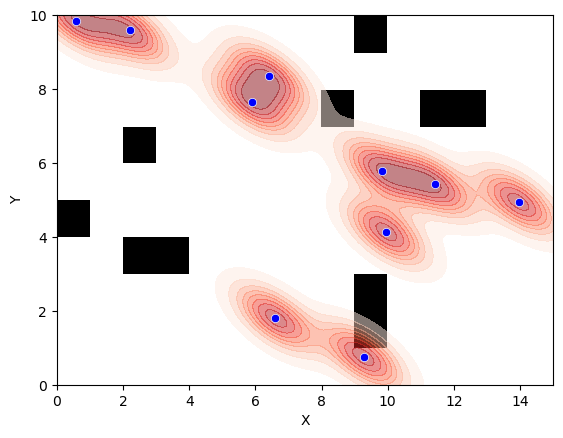

In [12]:
simul_clip_export('C:/Users', result_df, space, 'contact_exper.mp4')

-------------------

## 4) multiple sub-observed data

In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [25]:
import warnings
warnings.filterwarnings(action='ignore')

path = './Data/ObservedData/'

d2_timeComp = pd.read_csv(path + "day2_timeCompleteData.csv")
d2_timeComp.drop('Unnamed: 0', axis = 1, inplace = True)

#3~4hour
d2_3to4 = d2_timeComp[d2_timeComp['time'] >= 54000][d2_timeComp['time'] <= 57600]

#### fig 4 a)

In [27]:
# Exper: grid cells passed by each individual
import random


def Y1_cells(time, repet):
    cells = []
    for i in tqdm(range(repet)):
        t0 = random.randint(time[0], time[1])
        t1 = t0 + 3600  #300초
        filt = d2_3to4[d2_3to4['time']>= t0][d2_3to4['time']<= t1] #filt df extracted by 5 minutes interval

        uniqueId = pd.unique(filt['id']) 
           #한번 시행에서의 cell
        for ids in uniqueId:
            tem_df = filt[filt['id'] == ids]
            cells.append(len(pd.unique(tem_df['sid'])))   #cells designated by each cell
    return cells

cells = Y1_cells([54000,57600], 10)        
print(np.mean(cells))
observed = cells

100%|██████████| 10/10 [00:00<00:00, 10.10it/s]

5.832233223322333


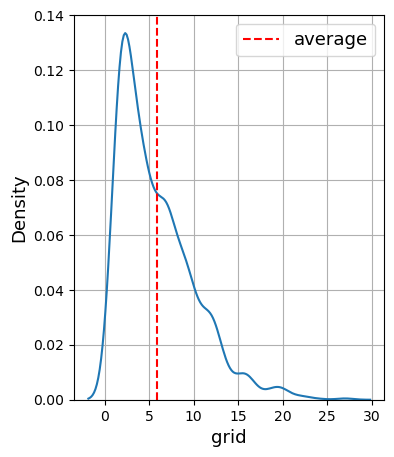

In [28]:
plt.figure(figsize=(4,5))

sns.kdeplot(observed)
plt.axvline(np.mean(observed), color='r', linestyle='--', label='average')
plt.grid()
plt.xlabel('grid', fontsize = 13)
plt.ylabel('Density', fontsize = 13)
plt.legend(fontsize = 13)
plt.show()

### fig 4 b)

In [34]:
#sensor distribution data
spacePath = 'C:/Users/MoongiChoi/Desktop/MG/양식, 코드 등/Python/Sequential_Calibration_with_SA/Data/ChinaVis 2019 Data Challenge-ICMTD Dataset/Sensor Distribution Data/'
sensorDistrib = pd.read_csv(spacePath + 'Sensor Distribution Data.csv')

d2_3to4 = d2_3to4[d2_3to4['time'] >= 54000][d2_3to4['time'] <= 55200]
d2_3to4.reset_index(drop = True, inplace = True)
d2_3to4['num'] = 1
d2_3to4_graph = d2_3to4.copy()
# How many people in each sid?
d2_3to4_graph = pd.merge(d2_3to4_graph, sensorDistrib[['sid','x', 'y']], on='sid', how='inner')

d2_3to4_graph = d2_3to4_graph.groupby(['sid', 'id']).agg({'num':'sum', 'x':'mean', 'y':'mean'}).reset_index()
d2_3to4_graph['num'] = 1

d2_3to4_graph = d2_3to4_graph.groupby('sid').agg({'num':'sum', 'x':'mean', 'y':'mean'}).reset_index()

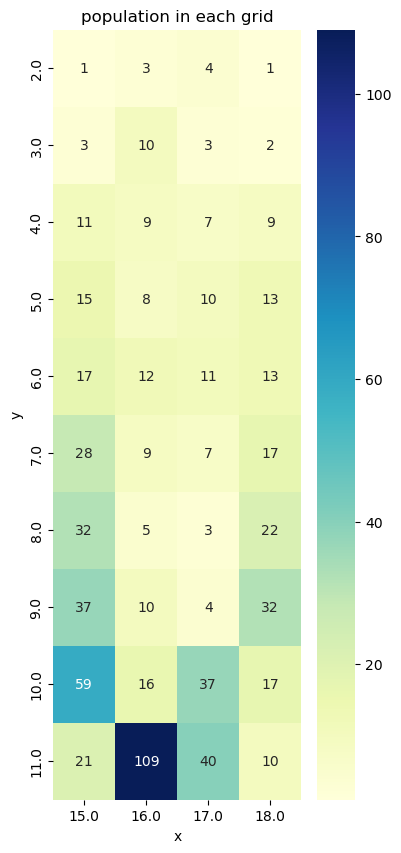

In [36]:
# Graph
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,10))

# pivot table: x, y - sum of num
pivoted = d2_3to4_graph.pivot_table(index='x', columns='y', values='num', aggfunc='sum')

# heatmap
sns.heatmap(pivoted, annot=True, fmt='d', cmap='YlGnBu')

# label and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('population in each grid')
plt.show()